In [1]:
import cv2
import lime
import os
import pandas as pd
import numpy as np
import keras
import random
import seaborn as sns
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from lime import lime_image
from keras import backend as K
from skimage.segmentation import mark_boundaries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import imagenet_utils

import sklearn.metrics as metrics
from keras.callbacks import LearningRateScheduler
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

In [2]:
LEPD_with_dust = [ 
    r"/kaggle/input/microplastic-dataset/dataset_microplastics-master/micro_plastic/LEPD_with_dust"
]
PE= [
        r"/kaggle/input/microplastic-dataset/dataset_microplastics-master/micro_plastic/PE"


]
PE_with_dust=[ r"/kaggle/input/microplastic-dataset/dataset_microplastics-master/micro_plastic/PE_with_dust"
        ]
   
    
PHA =[    
r"/kaggle/input/microplastic-dataset/dataset_microplastics-master/micro_plastic/PHA"
]

PHA_with_dust=[r"/kaggle/input/microplastic-dataset/dataset_microplastics-master/micro_plastic/PHA_with_dust"]

PS= [r"/kaggle/input/microplastic-dataset/dataset_microplastics-master/micro_plastic/PS"]

PS_with_dust=[r"/kaggle/input/microplastic-dataset/dataset_microplastics-master/micro_plastic/PS_with_dust"]

mixed=[r"/kaggle/input/microplastic-dataset/dataset_microplastics-master/micro_plastic/mixed"]

none =[r"/kaggle/input/microplastic-dataset/dataset_microplastics-master/micro_plastic/none"]

filepaths = []
labels = []
dict_lists = [LEPD_with_dust,PE,PE_with_dust, PHA, PHA_with_dust, PS,PS_with_dust, mixed,  none ]
class_labels = ["LEPD_with_dust","PE","PE_with_dust", "PHA", "PHA_with_dust", "PS","PS_with_dust", "mixed",  "none" ]

for i, dir_list in enumerate(dict_lists):
    for j in dir_list:
        flist = os.listdir(j)
        for f in flist:
            fpath = os.path.join(j, f)
            filepaths.append(fpath)
            labels.append(class_labels[i])

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
micro_data = pd.concat([Fseries, Lseries], axis=1)
micro_df = pd.DataFrame(micro_data)
print(micro_df.head())
print(micro_df["labels"].value_counts())

                                           filepaths          labels
0  /kaggle/input/microplastic-dataset/dataset_mic...  LEPD_with_dust
1  /kaggle/input/microplastic-dataset/dataset_mic...  LEPD_with_dust
2  /kaggle/input/microplastic-dataset/dataset_mic...  LEPD_with_dust
3  /kaggle/input/microplastic-dataset/dataset_mic...  LEPD_with_dust
4  /kaggle/input/microplastic-dataset/dataset_mic...  LEPD_with_dust
labels
mixed             191
PHA               118
PS                 86
PE                 80
PE_with_dust       78
LEPD_with_dust     56
PHA_with_dust      40
none               36
PS_with_dust       34
Name: count, dtype: int64


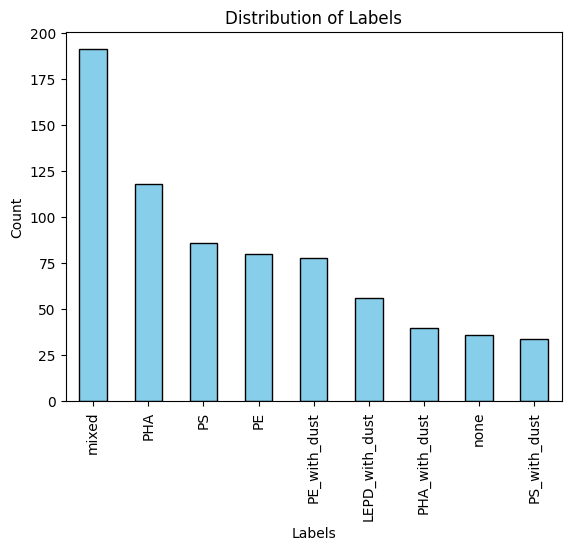

In [3]:
import matplotlib.pyplot as plt

# Plot the value counts of "labels" as a bar plot
label_counts = micro_df["labels"].value_counts()
label_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Add titles and labels
plt.title("Distribution of Labels")
plt.xlabel("Labels")
plt.ylabel("Count")

# Show the plot
plt.show()


In [4]:
import os
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

# Create directory for augmented images
save_dir = '/kaggle/working/augmented_images/'
os.makedirs(save_dir, exist_ok=True)

# Step 1: Check class distribution to identify the target number for balancing
class_counts = micro_df["labels"].value_counts()
max_count = class_counts.max()
print("Class distribution before augmentation:\n", class_counts)

# Step 2: Initialize ImageDataGenerator for binary images
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

augmented_filepaths = []
augmented_labels = []

# Step 3: Augment images for underrepresented classes
for label in class_counts.index:
    current_count = class_counts[label]
    if current_count < max_count:
        # Filter the DataFrame for the current class and get file paths
        class_images = micro_df[micro_df["labels"] == label]["filepaths"].values
        num_to_generate = max_count - current_count
        i = 0  # Counter for generated images

        # Augment images
        while i < num_to_generate:
            for filepath in class_images:
                try:
                    # Load the binary (grayscale) image and convert to array
                    image = Image.open(filepath).convert('L')
                    image = np.array(image)

                    # Reshape for ImageDataGenerator (requires batch size dimension)
                    image = image.reshape((1, *image.shape, 1))  # 1 channel for binary images

                    # Generate augmented images
                    for batch in datagen.flow(image, batch_size=1):
                        augmented_image = Image.fromarray(batch[0].reshape(image.shape[1], image.shape[2]).astype('uint8'))
                        new_path = os.path.join(save_dir, f"{label}_aug{i}.jpg")

                        # Save the augmented image to the new writable directory
                        augmented_image.save(new_path)

                        # Append to lists
                        augmented_filepaths.append(new_path)
                        augmented_labels.append(label)
                        i += 1

                        # Stop once target count is reached
                        if i >= num_to_generate:
                            break
                except Exception as e:
                    print(f"Error loading or processing file {filepath}: {e}")
                if i >= num_to_generate:
                    break

# Step 4: Add augmented data to DataFrame if augmentation was successful
if augmented_filepaths:
    augmented_data = pd.DataFrame({
        "filepaths": augmented_filepaths,
        "labels": augmented_labels
    })
    micro_df = pd.concat([micro_df, augmented_data], ignore_index=True)
    print("Class distribution after augmentation:\n", micro_df["labels"].value_counts())
else:
    print("No images were augmented.")


Class distribution before augmentation:
 labels
mixed             191
PHA               118
PS                 86
PE                 80
PE_with_dust       78
LEPD_with_dust     56
PHA_with_dust      40
none               36
PS_with_dust       34
Name: count, dtype: int64
Class distribution after augmentation:
 labels
LEPD_with_dust    191
PE                191
PE_with_dust      191
PHA               191
PHA_with_dust     191
PS                191
PS_with_dust      191
mixed             191
none              191
Name: count, dtype: int64


In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split

# First, split the data into training+validation (80%) and testing (20%)
train_val, test_set = train_test_split(micro_df, test_size=0.2, random_state=42, stratify=micro_df["labels"])

# Then, split the training+validation set into training (87.5% of train_val or 70% of total)
# and validation (12.5% of train_val or 10% of total)
train_set, val_set = train_test_split(train_val, test_size=0.125, random_state=42, stratify=train_val["labels"])

# Shuffle the data (optional but can improve randomness of batches in training)
train_set = train_set.sample(frac=1, random_state=42).reset_index(drop=True)
val_set = val_set.sample(frac=1, random_state=42).reset_index(drop=True)
test_set = test_set.sample(frac=1, random_state=42).reset_index(drop=True)

# Display the sizes of the resulting datasets
print(f"Training set size: {len(train_set)} ({len(train_set) / len(micro_df) * 100:.2f}%)")
print(f"Validation set size: {len(val_set)} ({len(val_set) / len(micro_df) * 100:.2f}%)")
print(f"Testing set size: {len(test_set)} ({len(test_set) / len(micro_df) * 100:.2f}%)")


Training set size: 1203 (69.98%)
Validation set size: 172 (10.01%)
Testing set size: 344 (20.01%)


In [6]:
import tensorflow as tf
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the sharpening function
def sharpen_image(image):
    # Convert the image to a numpy array (if it's not already)
    img_array = np.array(image)

    # Sharpening kernel
    kernel = np.array([[0, -1, 0],
                       [-1, 5,-1],
                       [0, -1, 0]])
    
    # Apply the sharpening kernel to the image using OpenCV
    sharpened = cv2.filter2D(img_array, -1, kernel)
    
    return sharpened

# Combine the sharpening function with MobileNetV2's preprocess_input function
def custom_preprocessing(image):
    # Apply sharpening
    sharpened = sharpen_image(image)
    # Apply MobileNetV2 preprocessing
    return tf.keras.applications.mobilenet_v2.preprocess_input(sharpened)

# Create an ImageDataGenerator with the custom preprocessing function
image_gen = ImageDataGenerator(preprocessing_function=custom_preprocessing)

# Define the data generators for train, test, and validation sets
train = image_gen.flow_from_dataframe(dataframe=train_set, x_col="filepaths", y_col="labels",
                                      target_size=(128, 128),
                                      color_mode='rgb',
                                      class_mode="categorical", 
                                      batch_size=64,
                                      shuffle=False
                                     )
test = image_gen.flow_from_dataframe(dataframe=test_set, x_col="filepaths", y_col="labels",
                                     target_size=(128, 128),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=64,
                                     shuffle=False
                                    )
val = image_gen.flow_from_dataframe(dataframe=val_set, x_col="filepaths", y_col="labels",
                                    target_size=(128, 128),
                                    color_mode='rgb',
                                    class_mode="categorical",
                                    batch_size=64,
                                    shuffle=False
                                   )


Found 1203 validated image filenames belonging to 9 classes.
Found 344 validated image filenames belonging to 9 classes.
Found 172 validated image filenames belonging to 9 classes.


In [7]:
from tensorflow import keras
from tensorflow.keras.layers import Add

# def residual_block(x, filters, kernel_size=3):
#     y = keras.layers.Conv2D(filters, kernel_size, padding='same')(x)
#     y = keras.layers.BatchNormalization()(y)
#     y = keras.layers.ELU()(y)  # Changed to ELU
#     y = keras.layers.Conv2D(filters, kernel_size, padding='same')(y)
#     y = keras.layers.BatchNormalization()(y)
#     y = Add()([y, x])
#     y = keras.layers.ELU()(y)  # Changed to ELU
#     return y
def residual_block(x, filters, kernel_size=3):
    # Shortcut connection to match the filter dimensions if needed
    shortcut = x
    if x.shape[-1] != filters:
        shortcut = keras.layers.Conv2D(filters, kernel_size=1, padding='same')(x)
    
    # Convolutional layers within the residual block
    y = keras.layers.Conv2D(filters, kernel_size, padding='same')(x)
    y = keras.layers.BatchNormalization()(y)
    y = keras.layers.ELU()(y)  # Changed to ELU
    y = keras.layers.Conv2D(filters, kernel_size, padding='same')(y)
    y = keras.layers.BatchNormalization()(y)
    
    # Add shortcut (adjusted if necessary) to the output of convolution layers
    y = Add()([y, shortcut])
    y = keras.layers.ELU()(y)  # Changed to ELU
    return y

input_layer = keras.Input(shape=(128, 128, 3))

x = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='elu')(input_layer)  # Changed to ELU
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='elu', padding="same")(x)  # Changed to ELU
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(pool_size=(2, 2))(x)

# Adding a residual block
x = residual_block(x, filters=64)
x = keras.layers.MaxPool2D(pool_size=(2, 2))(x)

x = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='elu', padding="same")(x)  # Changed to ELU
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='elu', padding="same")(x)  # Changed to ELU
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(pool_size=(2, 2))(x)

x = keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='elu', padding="same")(x)  # Changed to ELU
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='elu', padding="same")(x)  # Changed to ELU
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(pool_size=(2, 2))(x)

x = keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='elu', padding="same")(x)  # Changed to ELU
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='elu', padding="same")(x)  # Changed to ELU
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(pool_size=(2, 2))(x)
# Adding a residual block
x = residual_block(x, filters=64)
x = keras.layers.MaxPool2D(pool_size=(2, 2))(x)

x = keras.layers.Conv2D(filters=1024, kernel_size=(3, 3), activation='elu', padding="same")(x)  # Changed to ELU
x = keras.layers.BatchNormalization()(x)
x = keras.layers.GlobalAveragePooling2D()(x)  # Using Global Average Pooling

x = keras.layers.Dense(1024, activation='elu')(x)  # Changed to ELU
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(512, activation='elu')(x)  # Changed to ELU
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(128, activation='elu')(x)  # Changed to ELU
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(64, activation='elu')(x)  # Changed to ELU
x = keras.layers.Dropout(0.5)(x)
output_layer = keras.layers.Dense(9, activation='softmax')(x)

model = keras.models.Model(inputs=input_layer, outputs=output_layer)

# Create an instance of the Adam optimizer with custom parameters
adam_optimizer = keras.optimizers.Adam(
    learning_rate=0.001,  # Set your desired learning rate
    beta_1=0.9,  # The exponential decay rate for the 1st moment estimates
    beta_2=0.999,  # The exponential decay rate for the 2nd moment estimates
    epsilon=1e-07,  # A small constant for numerical stability
    amsgrad=False  # Whether to apply the AMSGrad variant of this algorithm
)
model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 126, 126,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 126, 126,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 126, 126,  │     18,496 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 126, 126,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 63, 63,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 63, 63,    │     36,928 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 63, 63,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ elu (ELU)           │ (None, 63, 63,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 63, 63,    │     36,928 │ elu[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 63, 63,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 63, 63,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ elu_1 (ELU)         │ (None, 63, 63,    │          0 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 31, 31,    │          0 │ elu_1[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 31, 31,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 31,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 31, 31,    │    147,584 │ batch_normalizat

 Total params: 7,357,065 (28.06 MB)

 Trainable params: 7,350,729 (28.04 MB)

 Non-trainable params: 6,336 (24.75 KB)

In [8]:

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

#checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("alzheimer_model.h5", save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)

In [9]:
history = model.fit(train, epochs=200, validation_data=val, verbose=1,callbacks=[lr_scheduler,early_stopping_cb])

Epoch 1/200


I0000 00:00:1735587782.248548      67 service.cc:145] XLA service 0x7be98c001b70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735587782.248603      67 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1735587782.248609      67 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 1/19 ━━━━━━━━━━━━━━━━━━━━ 10:06 34s/step - accuracy: 0.0625 - loss: 5.0726

I0000 00:00:1735587803.032162      67 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


19/19 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.2169 - loss: 3.5569 - val_accuracy: 0.3081 - val_loss: 2.0390 - learning_rate: 0.0100
Epoch 2/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 860ms/step - accuracy: 0.4485 - loss: 2.1200 - val_accuracy: 0.2267 - val_loss: 1.8465 - learning_rate: 0.0089
Epoch 3/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 835ms/step - accuracy: 0.5245 - loss: 1.6135 - val_accuracy: 0.3023 - val_loss: 1.7809 - learning_rate: 0.0079
Epoch 4/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 27s 873ms/step - accuracy: 0.6377 - loss: 1.2755 - val_accuracy: 0.2093 - val_loss: 1.8824 - learning_rate: 0.0071
Epoch 5/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 867ms/step - accuracy: 0.7117 - loss: 0.9410 - val_accuracy: 0.3140 - val_loss: 1.6368 - learning_rate: 0.0063
Epoch 6/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 888ms/step - accuracy: 0.7548 - loss: 0.7020 - val_accuracy: 0.2965 - val_loss: 1.7128 - learning_rate: 0.0056
Epoch 7/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 25s 900ms/step - accuracy: 0.7924 - loss: 0.6742 - v

In [10]:
model.evaluate(test, verbose=1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9864 - loss: 0.1607


[0.117359958589077, 0.9854651093482971]

In [11]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1) #pick class with highest probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 898ms/step


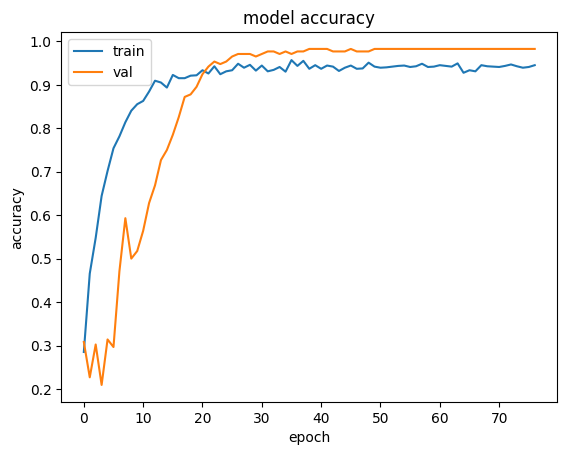

In [12]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

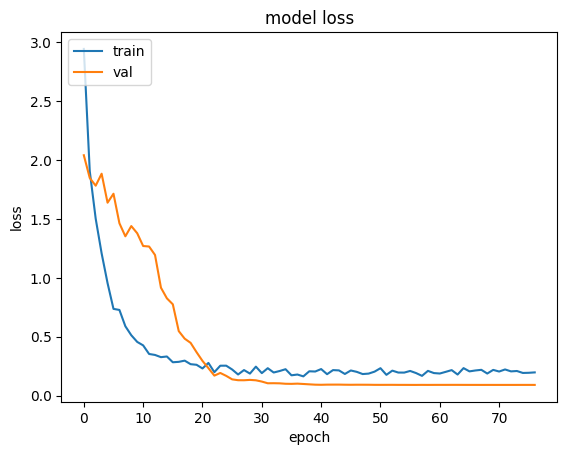

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [14]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_test = test.labels
y_test = [labels[k] for k in y_test]
print(classification_report(y_test, pred2))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred2)*100))

                precision    recall  f1-score   support

LEPD_with_dust       0.97      1.00      0.99        38
            PE       1.00      1.00      1.00        38
  PE_with_dust       0.97      1.00      0.99        38
           PHA       1.00      0.95      0.97        39
 PHA_with_dust       1.00      1.00      1.00        38
            PS       1.00      0.97      0.99        38
  PS_with_dust       1.00      1.00      1.00        39
         mixed       0.97      0.97      0.97        38
          none       0.95      0.97      0.96        38

      accuracy                           0.99       344
     macro avg       0.99      0.99      0.99       344
  weighted avg       0.99      0.99      0.99       344

Accuracy of the Model: 98.5%


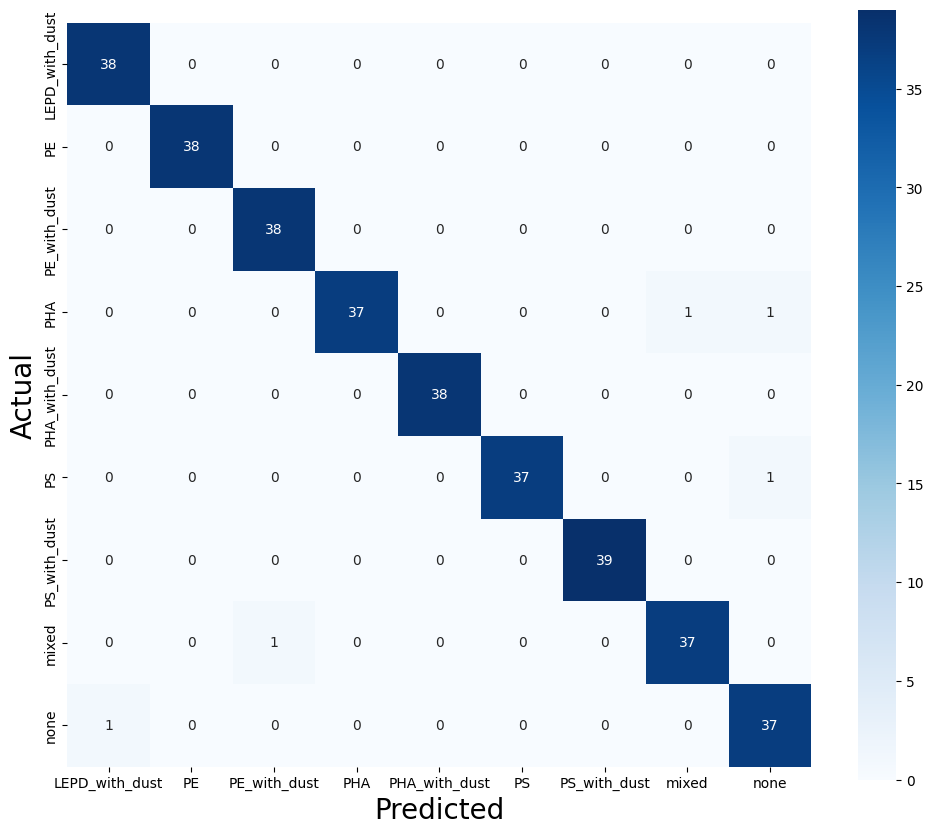

In [15]:
cm = confusion_matrix(y_test, pred2)


plt.figure(figsize=(12, 10))
ax = sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', square=True,xticklabels=micro_df["labels"].unique(), yticklabels=micro_df["labels"].unique())
ax.set_ylabel('Actual', fontsize=20)
ax.set_xlabel('Predicted', fontsize=20)
plt.show()

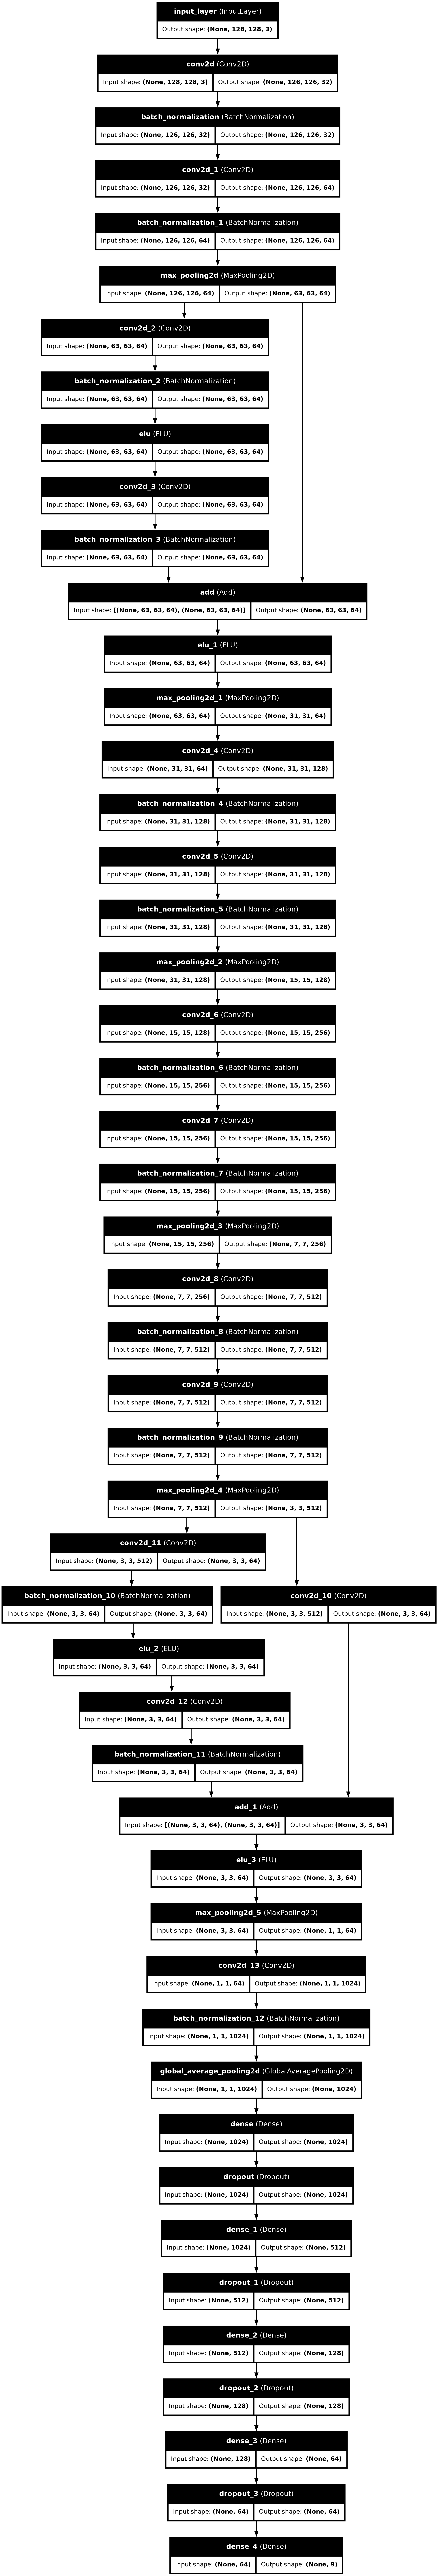

In [16]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [17]:

for i in range(len(model.layers)):
	# check for convolutional layer
	if 'conv' not in model.layers[i].name:
		continue
	# get filter weights
	filters, biases = model.layers[i].get_weights()
	print("layer number",i,model.layers[i].name, filters.shape)

layer number 1 conv2d (3, 3, 3, 32)
layer number 3 conv2d_1 (3, 3, 32, 64)
layer number 6 conv2d_2 (3, 3, 64, 64)
layer number 9 conv2d_3 (3, 3, 64, 64)
layer number 14 conv2d_4 (3, 3, 64, 128)
layer number 16 conv2d_5 (3, 3, 128, 128)
layer number 19 conv2d_6 (3, 3, 128, 256)
layer number 21 conv2d_7 (3, 3, 256, 256)
layer number 24 conv2d_8 (3, 3, 256, 512)
layer number 26 conv2d_9 (3, 3, 512, 512)
layer number 29 conv2d_11 (3, 3, 512, 64)
layer number 32 conv2d_12 (3, 3, 64, 64)
layer number 34 conv2d_10 (1, 1, 512, 64)
layer number 38 conv2d_13 (3, 3, 64, 1024)


In [18]:
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras
# Display
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

In [19]:
model_builder = keras.applications.xception.Xception
img_size = (128, 128)

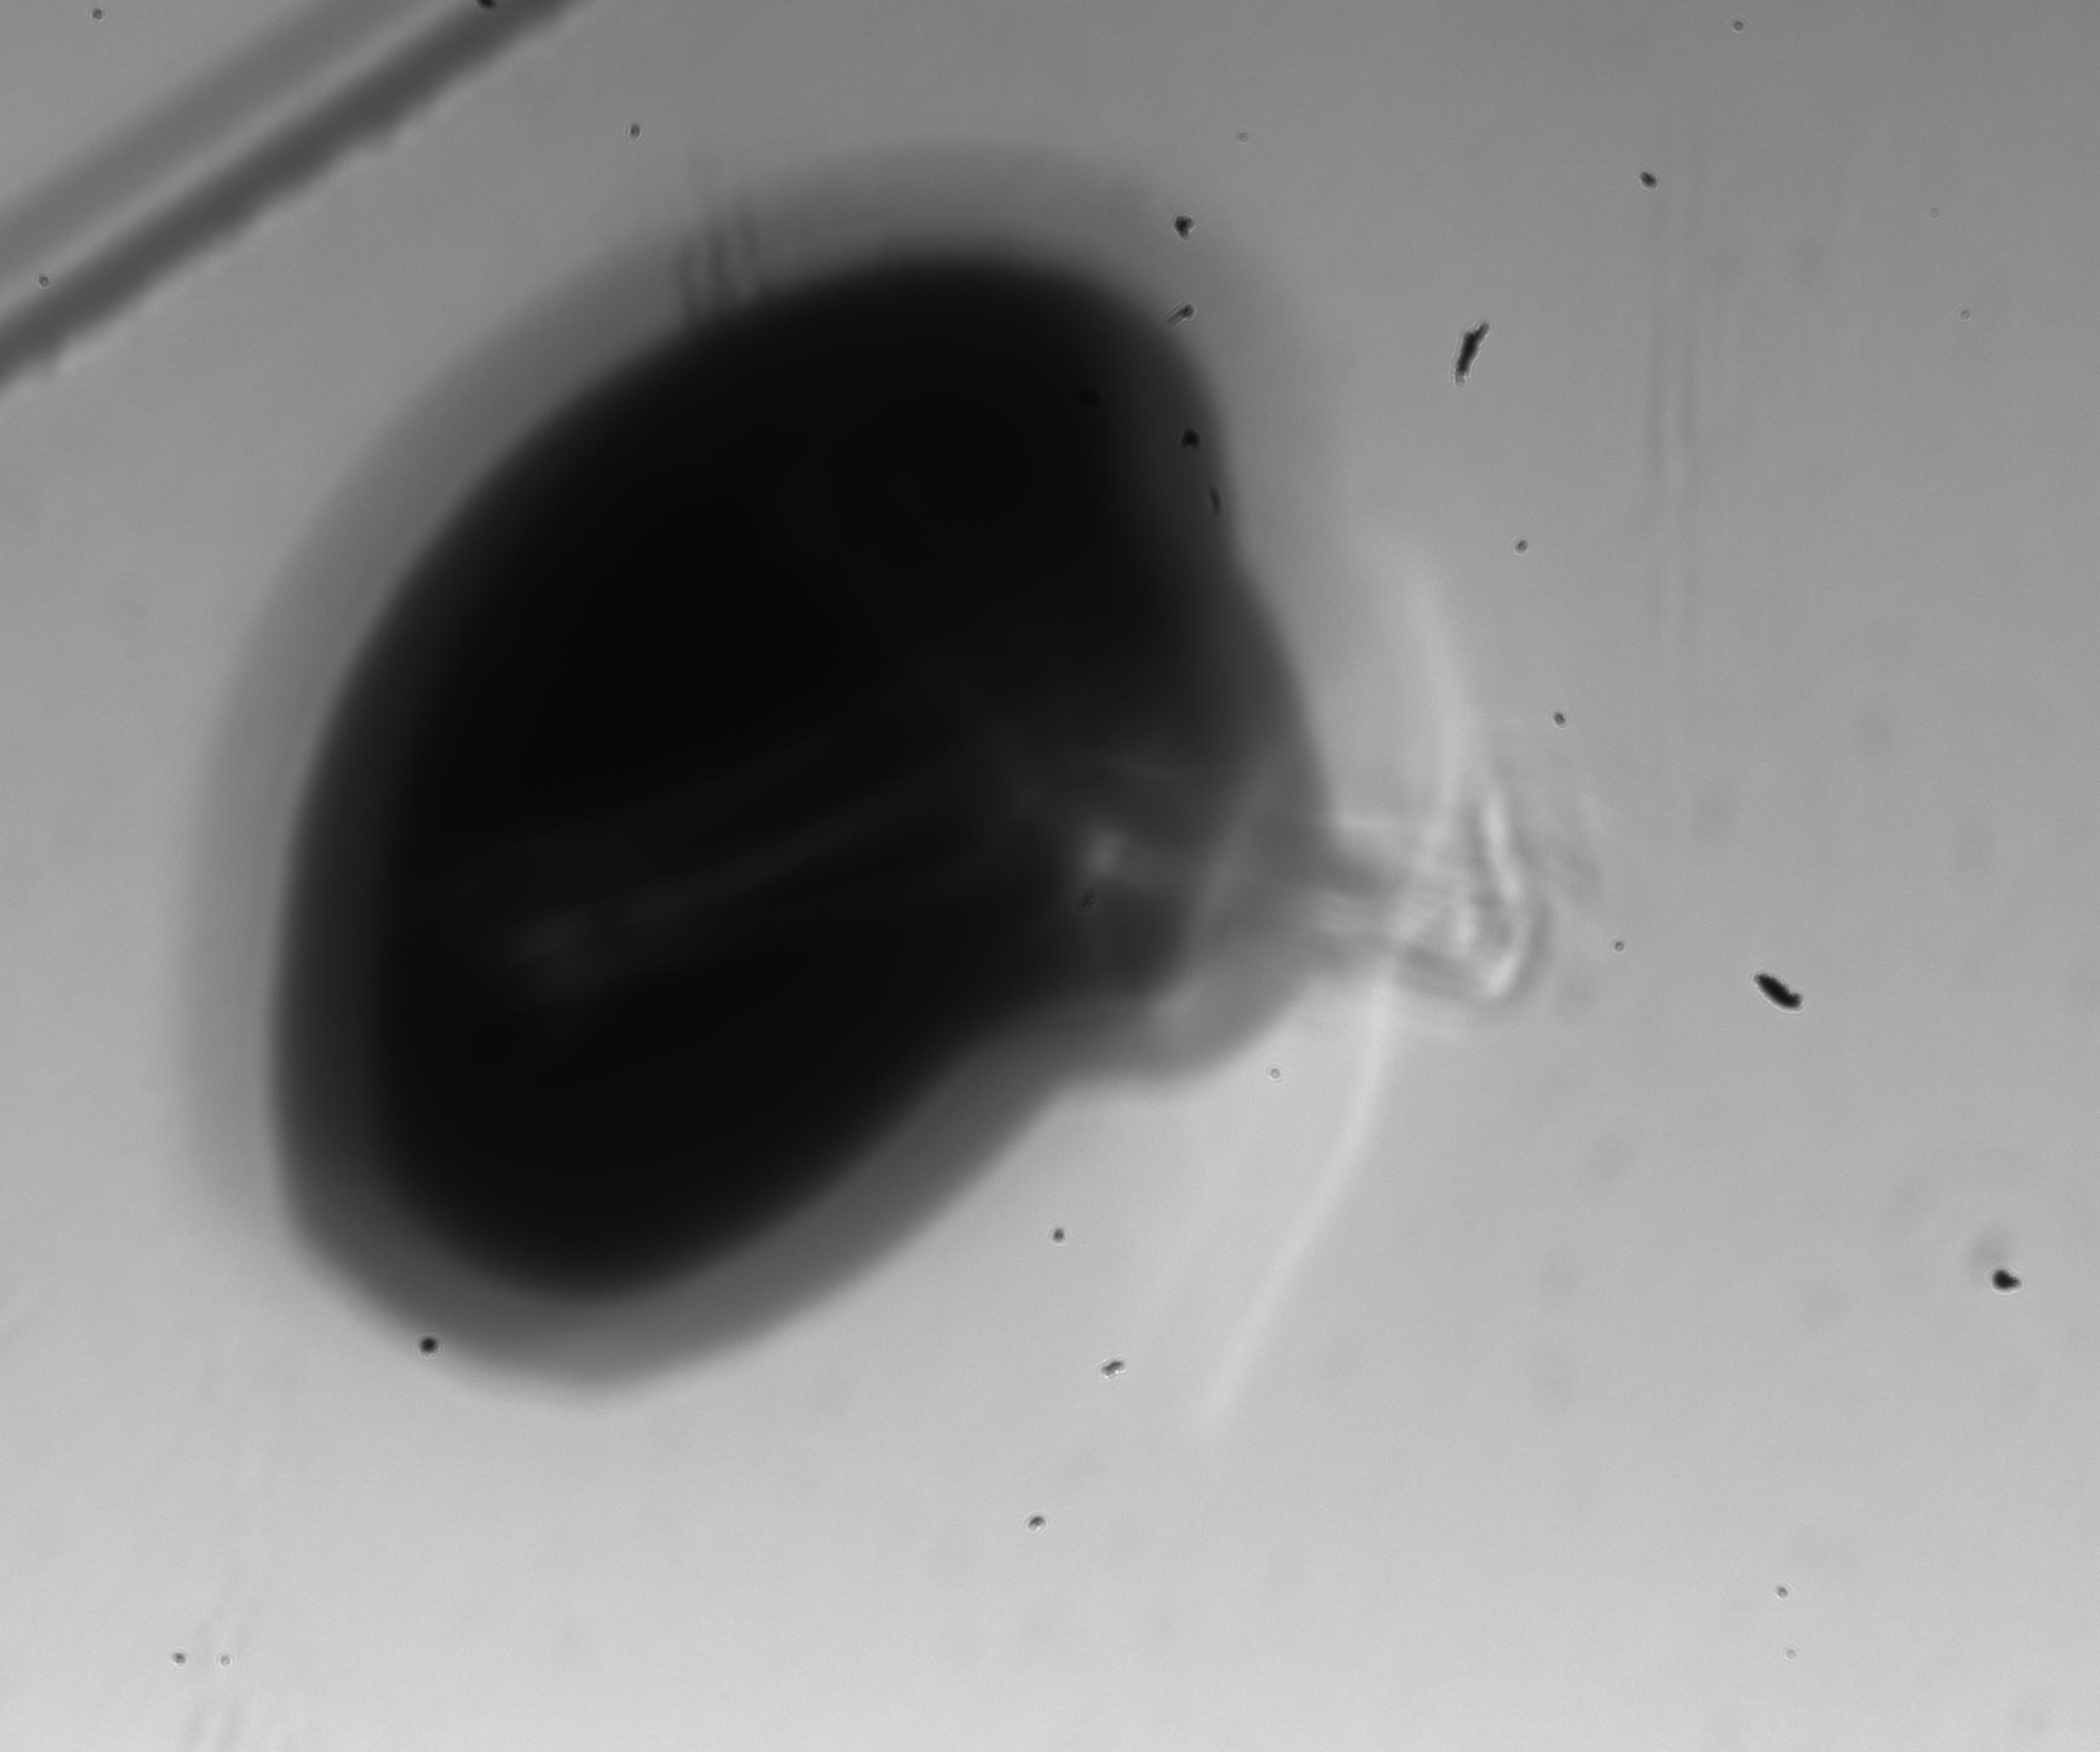

In [20]:
img_path= "/kaggle/input/microplastic-dataset/dataset_microplastics-master/micro_plastic/PE/11.jpg"

display(Image(img_path))

def get_img_array(img_path, size):
    ## `img` is a PIL image 
    img = keras.utils.load_img(img_path, target_size=size)
    array = keras.utils.img_to_array(img)
    ## We add a dimension to transform our array into a "batch"
    array = np.expand_dims(array, axis=0)
    return array

In [21]:
## Preparing the image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

In [22]:
def get_img_array(img_path, size):

    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (128, 128, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 128, 128, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

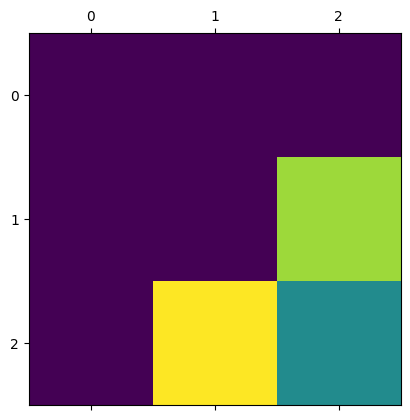

In [23]:
last_conv_layer_name = "conv2d_10"
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name,pred_index=1)

# Display heatmap
plt.matshow(heatmap)
plt.show()

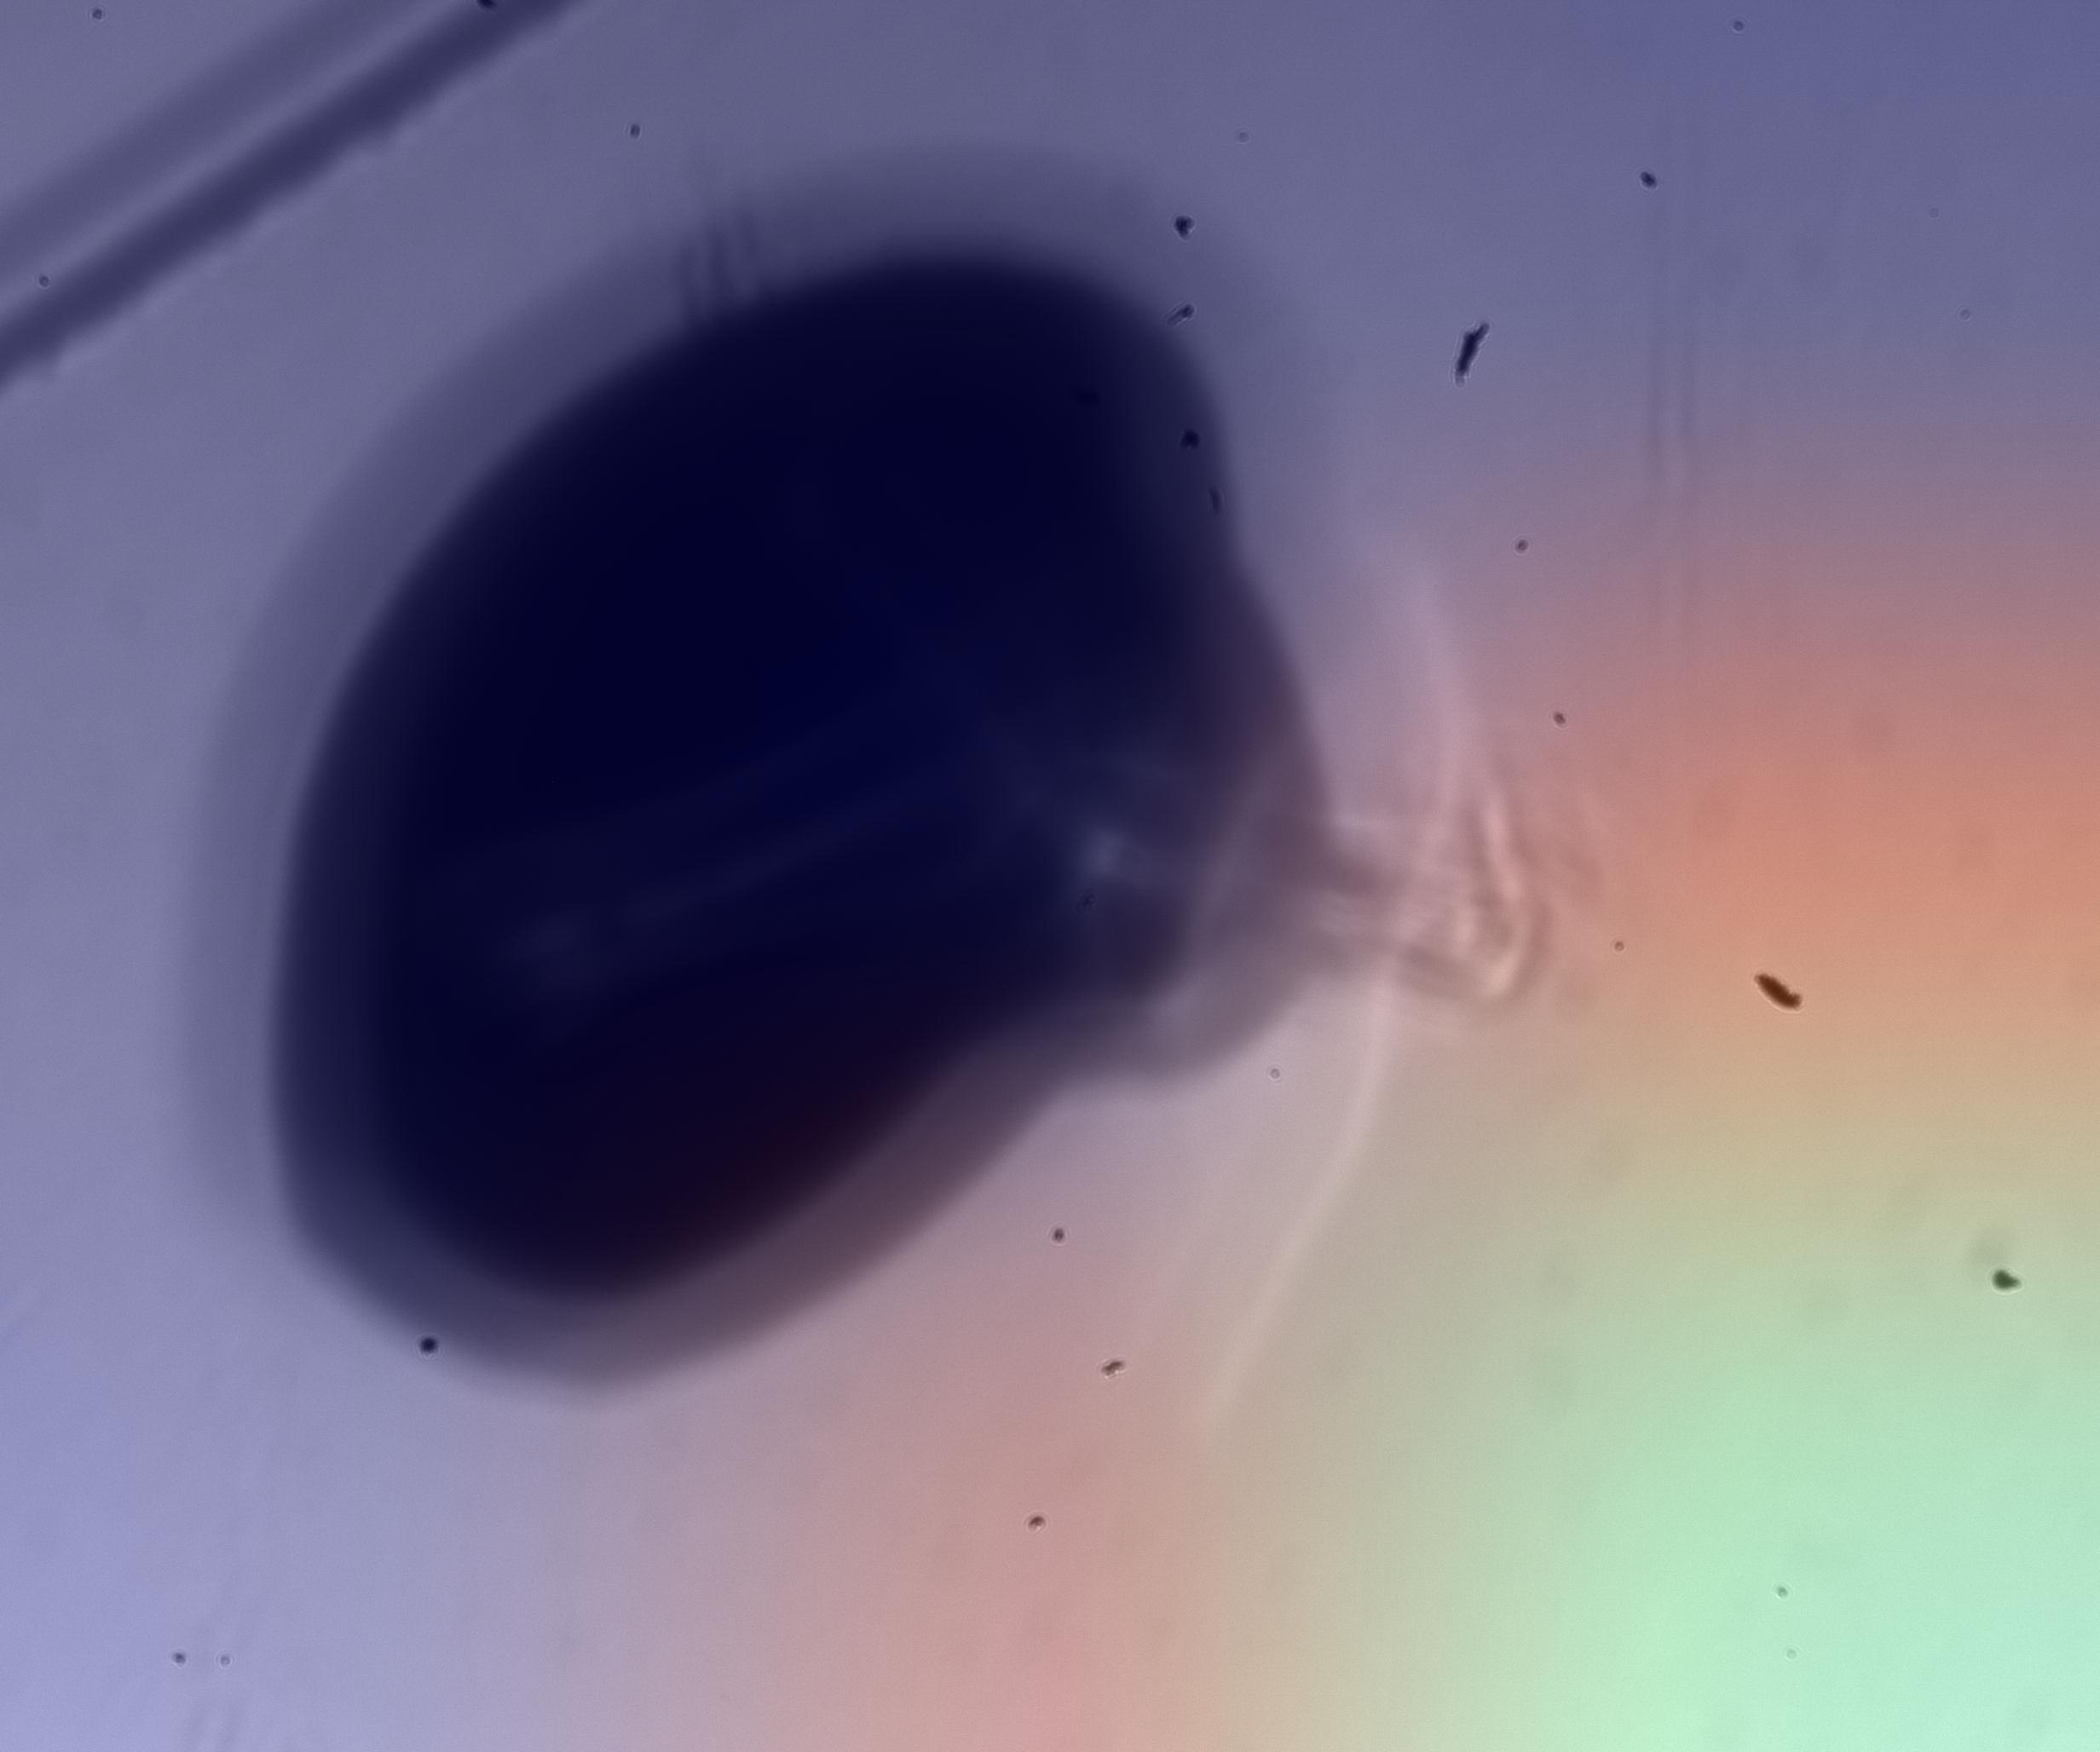

In [24]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)

In [25]:
model.save("microplastic_model.h5")

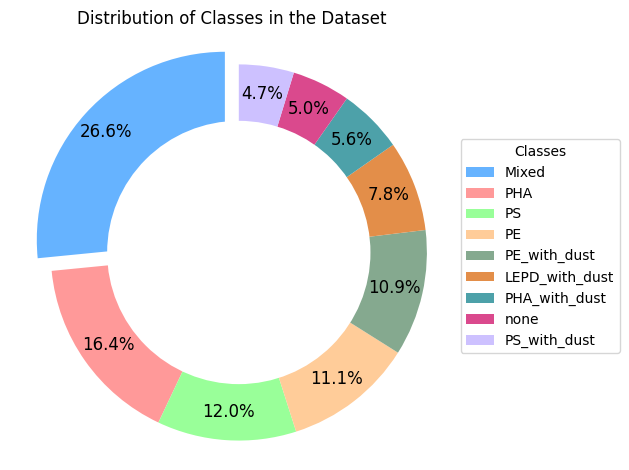

In [26]:
import matplotlib.pyplot as plt

# Data
labels = [
    "Mixed", "PHA", "PS", "PE", "PE_with_dust",
    "LEPD_with_dust", "PHA_with_dust", "none", "PS_with_dust"
]
sizes = [26.56, 16.41, 11.96, 11.13, 10.85, 7.79, 5.56, 5.01, 4.73]
oversample_size=[11.11,11.11,11.11,11.11,11.11,11.11,11.11,11.11,11.11,]
colors = ['#66b3ff','#ff9999','#99ff99','#ffcc99',
          "#85A98F", "#E38E49", "#4DA1A9", "#DA498D", "#CDC1FF"]  # Colors for each slice

# Calculate explode for the slice with the maximum percentage
explode = [0.1 if size == max(sizes) else 0 for size in sizes]

# Create a pie chart
fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(sizes, explode=explode, colors=colors,
                                   autopct='%1.1f%%', startangle=90, pctdistance=0.85)

# Draw a circle at the center of pie to make it look like a donut
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')  

# Customize the text
for text in autotexts:
    text.set_color('black')
    text.set_fontsize(12)

# Add a legend
plt.legend(wedges, labels, title="Classes", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

# Title
plt.title('Distribution of Classes in the Dataset')

# Show the plot
plt.tight_layout()
plt.show()

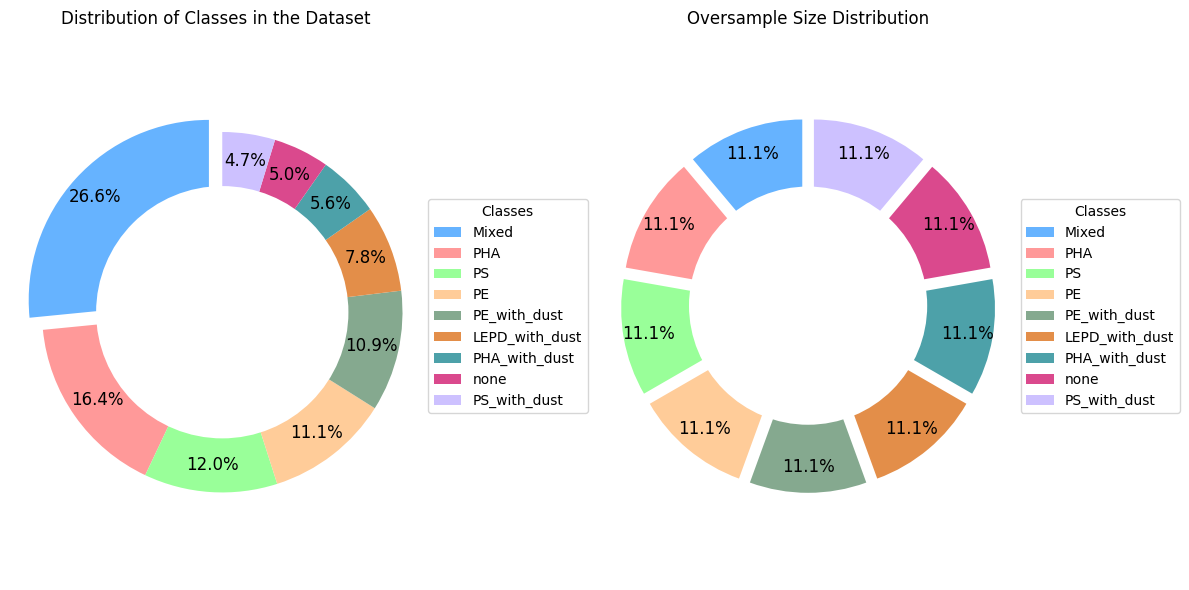

In [27]:
import matplotlib.pyplot as plt

# Data
labels = [
    "Mixed", "PHA", "PS", "PE", "PE_with_dust",
    "LEPD_with_dust", "PHA_with_dust", "none", "PS_with_dust"
]
sizes = [26.56, 16.41, 11.96, 11.13, 10.85, 7.79, 5.56, 5.01, 4.73]
oversample_size = [11.11, 11.11, 11.11, 11.11, 11.11, 11.11, 11.11, 11.11, 11.11]
colors = ['#66b3ff','#ff9999','#99ff99','#ffcc99',
          "#85A98F", "#E38E49", "#4DA1A9", "#DA498D", "#CDC1FF"]  # Colors for each slice

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Function to create a donut chart
def create_donut_chart(ax, sizes, labels, colors, title):
    # Calculate explode for the slice with the maximum percentage
    explode = [0.1 if size == max(sizes) else 0 for size in sizes]

    # Create a pie chart
    wedges, texts, autotexts = ax.pie(sizes, explode=explode, colors=colors,
                                       autopct='%1.1f%%', startangle=90, pctdistance=0.85)

    # Draw a circle at the center of pie to make it look like a donut
    centre_circle = plt.Circle((0, 0), 0.70, fc='white')
    ax.add_artist(centre_circle)

    # Equal aspect ratio ensures that pie is drawn as a circle
    ax.axis('equal')

    # Customize the text
    for text in autotexts:
        text.set_color('black')
        text.set_fontsize(12)

    # Add a legend
    ax.legend(wedges, labels, title="Classes", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

    # Title
    ax.set_title(title)

# Create the first donut chart for sizes
create_donut_chart(ax1, sizes, labels, colors, 'Distribution of Classes in the Dataset')

# Create the second donut chart for oversample_size
create_donut_chart(ax2, oversample_size, labels, colors, 'Oversample Size Distribution')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

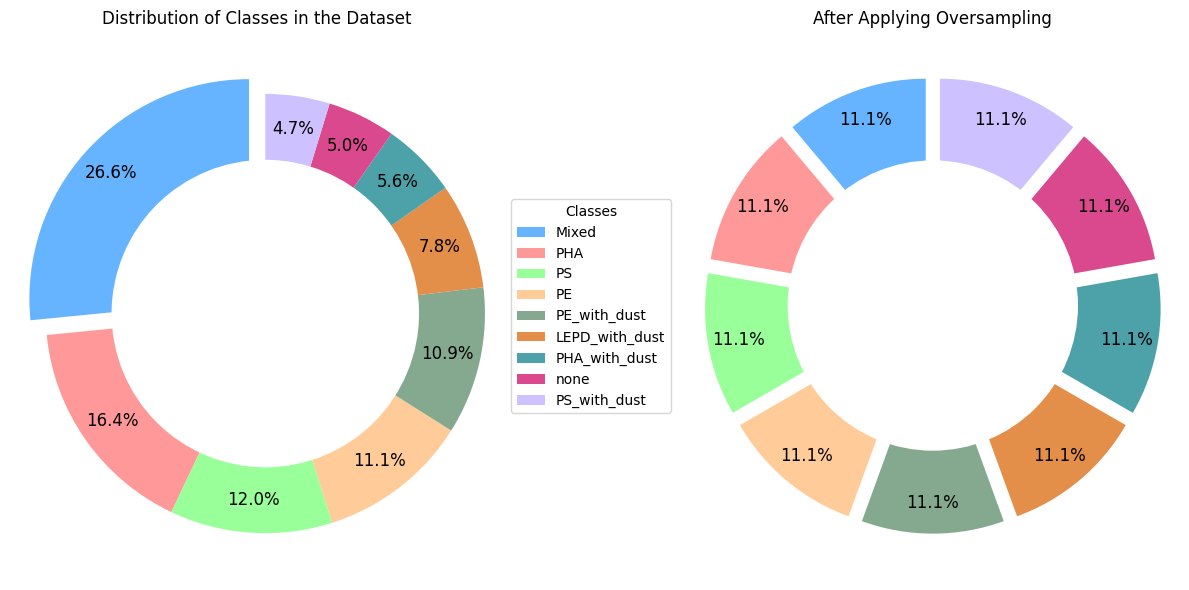

In [28]:
import matplotlib.pyplot as plt

# Data
labels = [
    "Mixed", "PHA", "PS", "PE", "PE_with_dust",
    "LEPD_with_dust", "PHA_with_dust", "none", "PS_with_dust"
]
sizes = [26.56, 16.41, 11.96, 11.13, 10.85, 7.79, 5.56, 5.01, 4.73]
oversample_size = [11.11, 11.11, 11.11, 11.11, 11.11, 11.11, 11.11, 11.11, 11.11]
colors = ['#66b3ff','#ff9999','#99ff99','#ffcc99',
          "#85A98F", "#E38E49", "#4DA1A9", "#DA498D", "#CDC1FF"]  # Colors for each slice

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Function to create a donut chart
def create_donut_chart(ax, sizes, labels, colors, title, show_legend=True):
    # Calculate explode for the slice with the maximum percentage
    explode = [0.1 if size == max(sizes) else 0 for size in sizes]

    # Create a pie chart
    wedges, texts, autotexts = ax.pie(sizes, explode=explode, colors=colors,
                                       autopct='%1.1f%%', startangle=90, pctdistance=0.85)

    # Draw a circle at the center of pie to make it look like a donut
    centre_circle = plt.Circle((0, 0), 0.70, fc='white')
    ax.add_artist(centre_circle)

    # Equal aspect ratio ensures that pie is drawn as a circle
    ax.axis('equal')

    # Customize the text
    for text in autotexts:
        text.set_color('black')
        text.set_fontsize(12)

    # Add a legend if specified
    if show_legend:
        ax.legend(wedges, labels, title="Classes", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

    # Title
    ax.set_title(title)

# Create the first donut chart for sizes
create_donut_chart(ax1, sizes, labels, colors, 'Distribution of Classes in the Dataset')

# Create the second donut chart for oversample_size without a legend
create_donut_chart(ax2, oversample_size, labels, colors, 'After Applying Oversampling', show_legend=False)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()